In [1]:
import math
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import MultipleLocator

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tabulate import tabulate

2025-02-25 09:29:38.225584: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-25 09:29:38.893673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Funciones para hacer gráficas
def plot_matriz_confusion(axes,TP=0,TN=0,FP=0,FN=0,fontsize=15,titulo=None,vpp=None,vpn=None,sensibilidad=None,especificidad=None,f1_score=None,mcc=None,auc=None,prevalencia=None):
    success_color=matplotlib.colors.to_rgb('#9EE548')
    failure_color=matplotlib.colors.to_rgb("#C32240")
    blanco_color=matplotlib.colors.to_rgb("#FFFFFF")


    if ((vpp is not None) | 
        (vpn is not None) | 
        (sensibilidad is not None) |
        (especificidad is not None) | 
        (prevalencia is not None) |
        (f1_score is not None) | 
        (mcc is not None) |
        (auc is not None) ):
        show_metrics=True
    else:
        show_metrics=False


    if show_metrics==False:
        axes.imshow([[success_color,failure_color],[failure_color,success_color]])
    else:
        axes.imshow([[success_color,failure_color,blanco_color],[failure_color,success_color,blanco_color],[blanco_color,blanco_color,blanco_color]])


    if titulo==None:
        titulo="Predicción"
    else:
        titulo=titulo+"\nPredicción"

    labels = ['Positivo','Negativo']
    xaxis = np.arange(len(labels))
    axes.set_xticks(xaxis)
    axes.set_yticks(xaxis)
    axes.set_xticklabels(labels, fontsize=13, color="#003B80")
    axes.set_yticklabels(labels, fontsize=13, color="#003B80")
    axes.text(0, 0, str(TP)+" TP",ha="center", va="center", color="#0A2102",fontsize=fontsize)
    axes.text(0, 1, str(FP)+" FP",ha="center", va="center", color="#FAEAEA",fontsize=fontsize) 
    axes.text(1, 0, str(FN)+" FN",ha="center", va="center", color="#FAEAEA",fontsize=fontsize)
    axes.text(1, 1, str(TN)+" TN",ha="center", va="center", color="#0A2102",fontsize=fontsize)         
    axes.xaxis.tick_top()
    axes.set_xlabel(titulo, fontsize=fontsize, color="#003B80") 
    axes.xaxis.set_label_position('top') 
    axes.set_ylabel('Realidad', fontsize=fontsize, color="#003B80") 


    if show_metrics==True:


        if (vpp is not None):
            axes.text(0, 2, f"Precision\n{vpp:.2f}",ha="center", va="center", color="#0A2102",fontsize=fontsize-4)
        if (vpn is not None):
            axes.text(1, 2, f"VPN\n{vpn:.2f}",ha="center", va="center", color="#0A2102",fontsize=fontsize-4)
        if (sensibilidad is not None):
            axes.text(2, 0, f"Sensibilidad\n{sensibilidad:.2f}",ha="center", va="center", color="#0A2102",fontsize=fontsize-4) 
        if (especificidad is not None):
            axes.text(2, 1, f"Especificidad\n{especificidad:.2f}",ha="center", va="center", color="#0A2102",fontsize=fontsize-4) 

        metricas_generales=""
        if (prevalencia is not None):
            metricas_generales=metricas_generales+f"Prevalencia\n{prevalencia:.2f}\n"        
        if (f1_score is not None):
            metricas_generales=metricas_generales+f"F1-score\n{f1_score:.2f}\n"   
        if (mcc is not None):
            metricas_generales=metricas_generales+f"MCC\n{mcc:.2f}\n"  
        if (auc is not None):
            metricas_generales=metricas_generales+f"AUC\n{auc:.2f}"             

        axes.text(2, 2, metricas_generales,ha="center", va="center", color="#0A2102",fontsize=fontsize-4)          

def axes_configure_labels(axes,title,xlabel,ylabel):
    color="#003B80"
    facecolor="#FAFCFF"
    gridcolor="#BAD4F2"
    tickcolor="#011E32"
    fontsize_label=13
 
    axes.set_xlabel(xlabel, fontsize=fontsize_label,color=color)
    axes.set_ylabel(ylabel, fontsize=fontsize_label,color=color)
    axes.set_title(title,color=color)
 
    axes.set_facecolor(facecolor)
    axes.spines['bottom'].set_color(tickcolor)
    axes.spines['top'].set_color(tickcolor)
    axes.spines['right'].set_color(tickcolor)
    axes.spines['left'].set_color(tickcolor)
    axes.tick_params(axis='both', colors=tickcolor)
 
    axes.grid(visible=True, which='major', axis='both',color=gridcolor,linewidth=1,zorder=-10)
    axes.set_axisbelow(True)
 
    handles, labels = axes.get_legend_handles_labels()
    if labels:
        axes.legend(fontsize=fontsize_label-2,labelcolor=color)


def axes_configure_axis_for_metrics(axes):
    axes.set_xlim(xmin=0,xmax=1)
    axes.set_ylim(ymin=0,ymax=1.1)
 
    axes.xaxis.set_major_locator(MultipleLocator(0.1))
    axes.yaxis.set_major_locator(MultipleLocator(0.1))

In [3]:
#Funciones del tema anterior
def get_datos(seed=42):
    datos=load_breast_cancer()
    x=datos.data
    y=datos.target

    x_train, x_test_validacion, y_train, y_test_validacion = train_test_split(x, y, test_size=0.6, random_state=seed,stratify=y)

    x_validacion, x_test, y_validacion, y_test =train_test_split(x_test_validacion, y_test_validacion, test_size=0.5, random_state=seed,stratify=y_test_validacion)

    return x_train, x_validacion, x_test,y_train, y_validacion, y_test

def get_y_pred(y_score,threshold):
    return y_score>threshold

def get_matriz_confusion(y_true,y_score,threshold):

    y_pred=get_y_pred(y_score,threshold)

    TP=sum((y_true==1) & (y_pred==1))
    TN=sum((y_true==0) & (y_pred==0))
    FP=sum((y_true==0) & (y_pred==1))
    FN=sum((y_true==1) & (y_pred==0))


    return TP,TN,FP,FN

def div_not_nan(a,b):
    if (b==0):
        return 0
    else:
        return a/b
    

def get_metrics(TP,TN,FP,FN,prevalencia=None):
    sensibilidad=div_not_nan(TP,TP+FN)
    especificidad=div_not_nan(TN,TN+FP)
    prevalencia_datos=(TP+FN)/(TP+FP+TN+FN)

    if (prevalencia==None):
        vpp=div_not_nan(TP,TP+FP)
        vpn=div_not_nan(TN,TN+FN)
    else:
        vpp=div_not_nan(sensibilidad*prevalencia,sensibilidad*prevalencia+(1-especificidad)*(1-prevalencia))
        vpn=div_not_nan(especificidad*(1-prevalencia),especificidad*(1-prevalencia)+(1-sensibilidad)*prevalencia)




    return sensibilidad,especificidad,vpp,vpn,prevalencia_datos

def specificity(y_true, y_score,threshold = 0.5):
    
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_score > threshold, dtype='float32')



    y_true = tf.reshape(y_true, (-1, 1))
    y_pred = tf.reshape(y_pred, (-1, 1))


    TN = K.sum((1 - y_true) * (1 - y_pred))  
    FP = K.sum((1 - y_true) * y_pred)        

    specificity = TN / (TN + FP + K.epsilon())  

    return specificity

In [11]:
#Ejercicio 1.A
new_model=tf.keras.models.load_model('mymodel.keras',custom_objects={"specificity": specificity})
x_train, x_validacion, x_test,y_train, y_validacion, y_test=get_datos()
y_score=new_model.predict(x_test,verbose=False).reshape(-1)
y_true=y_test

def get_metrics_independientes_prevalencia(y_true, y_score,threshold = 0.5):
    TP,TN,FP,FN=get_matriz_confusion(y_true,y_score,threshold=threshold)
    sensibilidad,especificidad,vpp,vpn,prevalencia=get_metrics(TP,TN,FP,FN)

    informedness_normalizado=(sensibilidad+especificidad)/2
    balanced_accuracy=informedness_normalizado
    prevalence_threshold=math.sqrt(1-especificidad)/(math.sqrt(sensibilidad)+math.sqrt(1-especificidad))
    roc_auc=roc_auc_score(y_true,y_score)

    return informedness_normalizado,balanced_accuracy,prevalence_threshold,roc_auc

informedness_normalizado,balanced_accuracy,prevalence_threshold,roc_auc=get_metrics_independientes_prevalencia(y_true, y_score)


metricas=[
    ["Informedness Normalizado",informedness_normalizado],
    ["Balanced Accuracy",balanced_accuracy],
    ["1-Prevalence Threshold",1-prevalence_threshold],   
    ["ROC-AUC",roc_auc]
]

print(tabulate(metricas,headers=["Métrica","Valor"]))

Métrica                      Valor
------------------------  --------
Informedness Normalizado  0.892304
Balanced Accuracy         0.892304
1-Prevalence Threshold    0.719498
ROC-AUC                   0.924796


In [5]:
#Ejercicio 1.B
def get_metrics_rendimiento_global(y_true, y_score,threshold = 0.5,prevalencia=None):
    TP,TN,FP,FN=get_matriz_confusion(y_true,y_score,threshold=threshold)
    sensibilidad,especificidad,vpp,vpn,prevalencia_datos=get_metrics(TP,TN,FP,FN,prevalencia)

    if (prevalencia==None):
        prevalencia=prevalencia_datos

    accuracy=especificidad+(sensibilidad-especificidad)*prevalencia_datos
    mcc=( sensibilidad+especificidad-1 )/(math.sqrt( (prevalencia/(1-prevalencia))*sensibilidad-especificidad+1 )*math.sqrt( ((1-prevalencia)/prevalencia)*especificidad-sensibilidad+1 ))
    mcc_normalizado=(mcc+1)/2
    markedness=(vpp+vpn)/2
    return accuracy,mcc_normalizado,markedness

accuracy,mcc_normalizado,markedness=get_metrics_rendimiento_global(y_true, y_score)


metricas=[
    ["Accuracy",accuracy],
    ["MCC Normalizado",mcc_normalizado],
    ["Markedness",markedness]
]

print(tabulate(metricas,headers=["Métrica","Valor"]))

Métrica             Valor
---------------  --------
Accuracy         0.900585
MCC Normalizado  0.893571
Markedness       0.894841


In [6]:
#Ejercicio 1.C
def get_metrics_datos_desbalaceados(y_true, y_score,threshold = 0.5,prevalencia=None):
    TP,TN,FP,FN=get_matriz_confusion(y_true,y_score,threshold=threshold)
    sensibilidad,especificidad,vpp,vpn,prevalencia_datos=get_metrics(TP,TN,FP,FN,prevalencia)
    precision=vpp

    jaccard= (precision*sensibilidad)/(precision+sensibilidad-precision*sensibilidad)
    f1_score= (2*precision*sensibilidad)/(precision+sensibilidad)
    fowlkes_mallows= math.sqrt( sensibilidad*precision )
    pr_auc=average_precision_score(y_true,y_score)


    return jaccard,f1_score,fowlkes_mallows,pr_auc

jaccard,f1_score,fowlkes_mallows,pr_auc=get_metrics_datos_desbalaceados(y_true, y_score)


metricas=[
    ["Jaccard",jaccard],
    ["F1-score",f1_score],
    ["Fowlkes Mallows",fowlkes_mallows],
    ["PR-AUC",pr_auc]
]

print(tabulate(metricas,headers=["Métrica","Valor"]))

Métrica             Valor
---------------  --------
Jaccard          0.853448
F1-score         0.92093
Fowlkes Mallows  0.92094
PR-AUC           0.921876


In [7]:
#Ejercicio 2.A 

#Porque justamente estas métricas son independientes de la prevalencia


/tmp/ipykernel_407232/3000628932.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  mcc=( sensibilidad+especificidad-1 )/(math.sqrt( (prevalencia/(1-prevalencia))*sensibilidad-especificidad+1 )*math.sqrt( ((1-prevalencia)/prevalencia)*especificidad-sensibilidad+1 ))


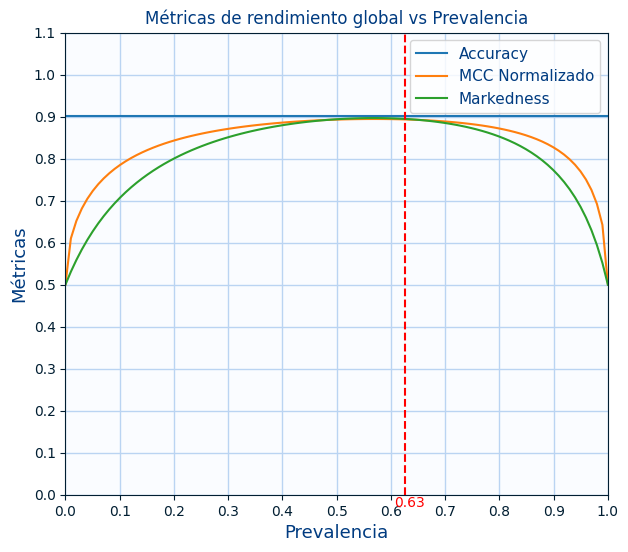

In [8]:
#Ejercicio 2.B

TP,TN,FP,FN=get_matriz_confusion(y_true,y_score,threshold=0.5)
sensibilidad,especificidad,vpp,vpn,prevalencia_datos=get_metrics(TP,TN,FP,FN)

prevalencias=np.linspace(0,1,100)
accuracy_s=[]
mcc_normalizado_s=[]
markedness_s=[]

for prevalencia in prevalencias:
    accuracy,mcc_normalizado,markedness=get_metrics_rendimiento_global(y_true, y_score,prevalencia=prevalencia)
    accuracy_s.append(accuracy)
    mcc_normalizado_s.append(mcc_normalizado)
    markedness_s.append(markedness)
    

figure=plt.figure(figsize=(7, 6)) 
axes=figure.add_subplot(1,1,1)
 
axes.plot(prevalencias,accuracy_s,linestyle="solid",label="Accuracy")
axes.plot(prevalencias,mcc_normalizado_s,linestyle="solid",label="MCC Normalizado")
axes.plot(prevalencias,markedness_s,linestyle="solid",label="Markedness")

#La prevalencia original
axes.vlines(x = prevalencia_datos, ymin = 0, ymax = 1.1,colors = '#ff0000',linestyle="dashed")
axes.text(prevalencia_datos-0.02,-0.03,f'{prevalencia_datos:0.2f}',c="#ff0000")

axes_configure_labels(axes,f"Métricas de rendimiento global vs Prevalencia","Prevalencia","Métricas")
axes_configure_axis_for_metrics(axes)



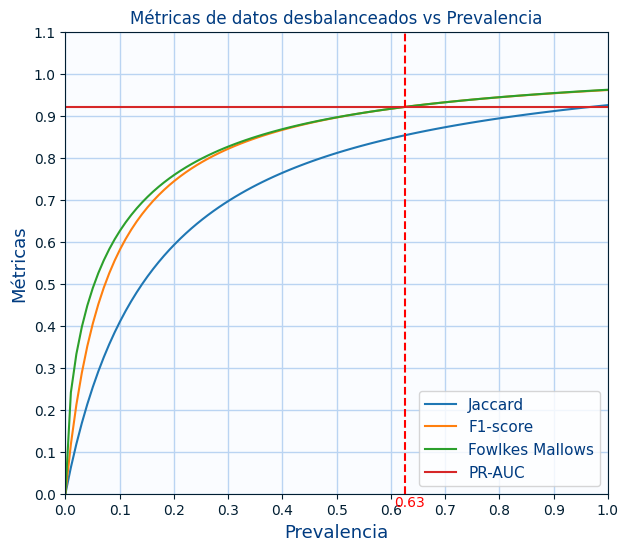

In [9]:
#Ejercicio 2.C

TP,TN,FP,FN=get_matriz_confusion(y_true,y_score,threshold=0.5)
sensibilidad,especificidad,vpp,vpn,prevalencia_datos=get_metrics(TP,TN,FP,FN)

prevalencias=np.linspace(0,1,100)
jaccard_s=[]
f1_score_s=[]
fowlkes_mallows_s=[]
pr_auc_s=[]

for prevalencia in prevalencias:
    jaccard,f1_score,fowlkes_mallows,pr_auc=get_metrics_datos_desbalaceados(y_true, y_score,prevalencia=prevalencia)

    jaccard_s.append(jaccard)
    f1_score_s.append(f1_score)    
    fowlkes_mallows_s.append(fowlkes_mallows)
    pr_auc_s.append(pr_auc)
    

figure=plt.figure(figsize=(7, 6)) 
axes=figure.add_subplot(1,1,1)
 
axes.plot(prevalencias,jaccard_s,linestyle="solid",label="Jaccard")
axes.plot(prevalencias,f1_score_s,linestyle="solid",label="F1-score")
axes.plot(prevalencias,fowlkes_mallows_s,linestyle="solid",label="Fowlkes Mallows")
axes.plot(prevalencias,pr_auc_s,linestyle="solid",label="PR-AUC")

#La prevalencia original
axes.vlines(x = prevalencia_datos, ymin = 0, ymax = 1.1,colors = '#ff0000',linestyle="dashed")
axes.text(prevalencia_datos-0.02,-0.03,f'{prevalencia_datos:0.2f}',c="#ff0000")


axes_configure_labels(axes,f"Métricas de datos desbalanceados vs Prevalencia","Prevalencia","Métricas")
axes.set_xlim(xmin=0,xmax=prevalencias[-1])
axes.set_ylim(ymin=0,ymax=1.1)
 
axes.xaxis.set_major_locator(MultipleLocator(prevalencias[-1]/10))
axes.yaxis.set_major_locator(MultipleLocator(0.1))

#PR-AUC no ha variado porque no se puede calcular según la prevalencia. Habría que tener datos con esa prevalencia.


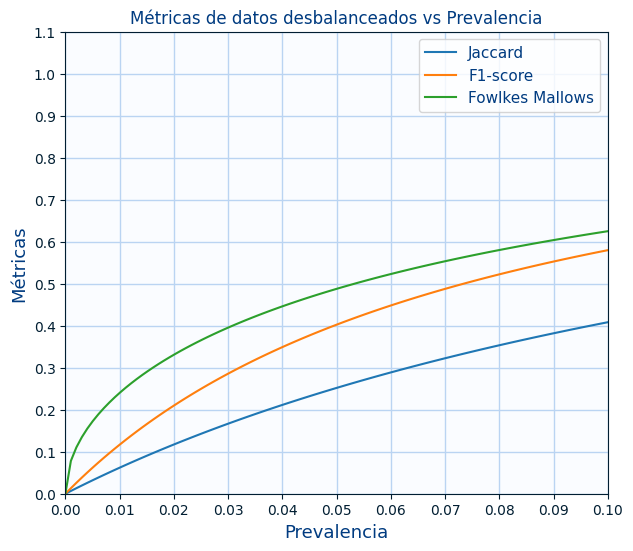

In [10]:
#Ejercicio 2.D

prevalencias=np.linspace(0,0.1,100)
jaccard_s=[]
f1_score_s=[]
fowlkes_mallows_s=[]
pr_auc_s=[]

for prevalencia in prevalencias:
    jaccard,f1_score,fowlkes_mallows,_=get_metrics_datos_desbalaceados(y_true, y_score,prevalencia=prevalencia)

    jaccard_s.append(jaccard)
    f1_score_s.append(f1_score)    
    fowlkes_mallows_s.append(fowlkes_mallows)
    

figure=plt.figure(figsize=(7, 6)) 
axes=figure.add_subplot(1,1,1)
 
axes.plot(prevalencias,jaccard_s,linestyle="solid",label="Jaccard")
axes.plot(prevalencias,f1_score_s,linestyle="solid",label="F1-score")
axes.plot(prevalencias,fowlkes_mallows_s,linestyle="solid",label="Fowlkes Mallows")

axes_configure_labels(axes,f"Métricas de datos desbalanceados vs Prevalencia","Prevalencia","Métricas")
axes.set_xlim(xmin=0,xmax=prevalencias[-1])
axes.set_ylim(ymin=0,ymax=1.1)
 
axes.xaxis.set_major_locator(MultipleLocator(prevalencias[-1]/10))
axes.yaxis.set_major_locator(MultipleLocator(0.1))